In [79]:
'''IMPORT'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sympy as sp
from sympy import symbols, Matrix
import pandas as pd
import pyvista as pv #para visualizar mallas
from dolfinx.io import XDMFFile #para guardar mallas en formato xdmf
import meshio #para leer mallas
from vtk import VTK_QUADRATIC_QUAD
import gmsh
import pandas as pd
import sympy as sp

### Ploteo de la malla con PyVista

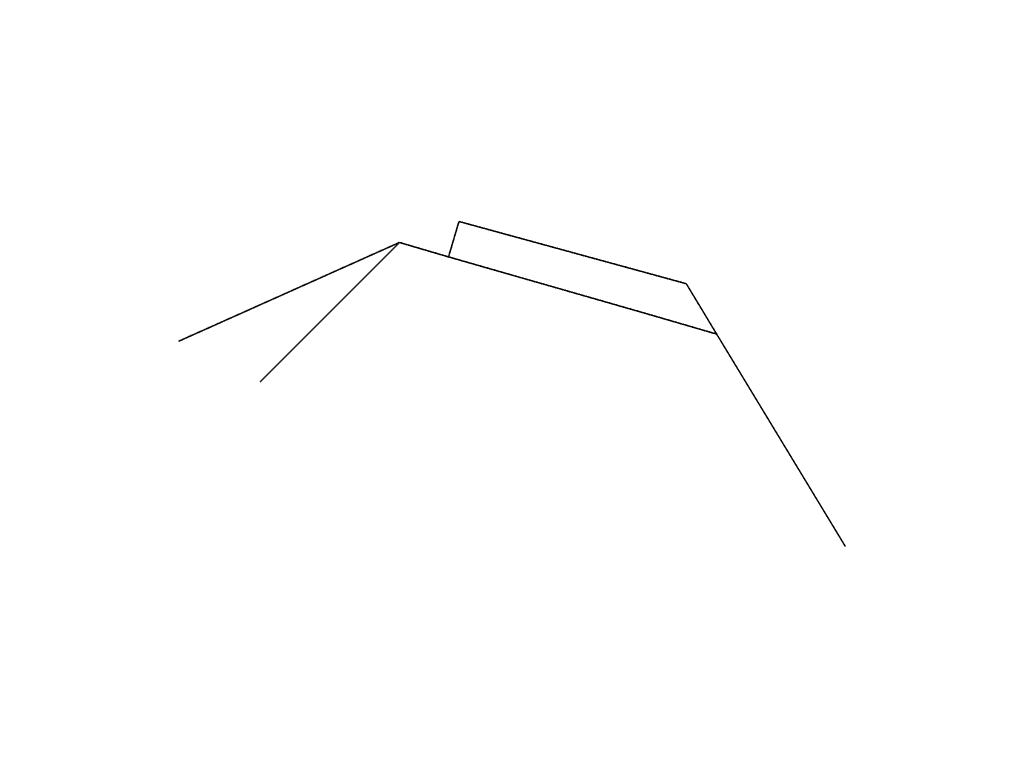

In [80]:
file_path = "mesh/TP1.msh"
mesh=meshio.read(file_path) #leo la malla

# Crear el plotter de PyVista
plotter = pv.Plotter()

# Crear la malla de PyVista
plotter.add_mesh(mesh, show_edges=True, color='black', line_width=1.5)


plotter.view_xy()  # Esto ajusta la vista para una malla 2D.

# Mostrar la malla
plotter.show()

### Connectivity table, dof tables

In [81]:
def read(file_path):
    """
    Lee una malla GMSH y devuelve:
      - tabla de conectividades
      - tabla de grados de libertad 
      - coordenadas por nodo
      - tipo de elemento por línea
      - tags y nodos por tipo de elemento
    """
    gmsh.initialize()
    gmsh.open(file_path)

    dofs_per_node = 3  # ux, uy, θz

    # === COORDENADAS DE NODOS ===
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    coords_by_node = {
        node_tags[i]: [node_coords[3*i], node_coords[3*i+1], node_coords[3*i+2]]
        for i in range(len(node_tags))
    }

    # === ELEMENTOS TIPO LÍNEA (ETYPE = 1) ===
    element_types, elem_tags_list, elem_node_tags_list = gmsh.model.mesh.getElements()
    rows_connectivity = []

    for etype, tags, node_tags in zip(element_types, elem_tags_list, elem_node_tags_list):
        if etype != 1:
            continue  # solo líneas con 2 nodos

        n_nodos_por_elem = len(node_tags) // len(tags)
        for i in range(len(tags)):
            nodes = node_tags[i*n_nodos_por_elem : (i+1)*n_nodos_por_elem]
            rows_connectivity.append(nodes)

    connectivity_table = np.array(rows_connectivity, dtype=int)
    number_of_elements = connectivity_table.shape[0]

    # === TABLA DE GDL ===
    dof_table = np.zeros((number_of_elements, dofs_per_node*2), dtype=int)

    for i in range(number_of_elements):
        n1, n2 = connectivity_table[i]
        dof_table[i, :] = [
            n1*dofs_per_node - 2, n1*dofs_per_node - 1, n1*dofs_per_node,
            n2*dofs_per_node - 2, n2*dofs_per_node - 1, n2*dofs_per_node
        ]

    # === CLASIFICACIÓN POR TIPO DE ELEMENTO ("Barra", "Viga", etc) ===
    groups = gmsh.model.getPhysicalGroups(dim=1)
    element_type = {}

    for dim, tag in groups:
        name = gmsh.model.getPhysicalName(dim, tag)
        line_ids = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
        for line_id in line_ids:
            element_type[line_id] = name

    gmsh.finalize()

    return connectivity_table, dof_table, coords_by_node, element_type, elem_tags_list, elem_node_tags_list

connectivity_table, dof_table, coords_by_node, element_type, elem_tags_list, elem_node_tags_list= read(file_path)

print('Tabla de conectividades: ')
print(connectivity_table)
print('Tabla de GdL: ')
print(dof_table)
print('Coordenadas por nodo: ')
print(coords_by_node)
print('Tipo de elemento: ')
print(element_type)

Info    : Reading 'mesh/TP1.msh'...
Info    : 20 entities
Info    : 10 nodes
Info    : 10 elements
Info    : Done reading 'mesh/TP1.msh'
Tabla de conectividades: 
[[ 1  3]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 4  9]
 [ 5  7]
 [ 9  6]
 [10  7]
 [10  8]
 [ 6 10]]
Tabla de GdL: 
[[ 1  2  3  7  8  9]
 [ 4  5  6  7  8  9]
 [ 7  8  9 10 11 12]
 [10 11 12 13 14 15]
 [10 11 12 25 26 27]
 [13 14 15 19 20 21]
 [25 26 27 16 17 18]
 [28 29 30 19 20 21]
 [28 29 30 22 23 24]
 [16 17 18 28 29 30]]
Coordenadas por nodo: 
{1: [0.0, 0.0, 0.0], 2: [-1256.0, 628.0, 0.0], 3: [2154.0, 2154.0, 0.0], 4: [2912.0, 1931.0, 0.0], 5: [3073.0, 2478.0, 0.0], 6: [7052.0, 739.0, 0.0], 7: [6583.0, 1517.0, 0.0], 8: [9040.0, -2541.0, 0.0], 9: [5901.0, 1074.0, 0.0], 10: [7052.0, 739.0, 0.0]}
Tipo de elemento: 
{1: 'Barra', 6: 'Barra', 2: 'Viga', 3: 'Viga', 4: 'Viga', 5: 'Viga', 7: 'Viga', 8: 'Viga', 9: 'Viga', 10: 'Conector'}


### Ploteo de la malla con matplot

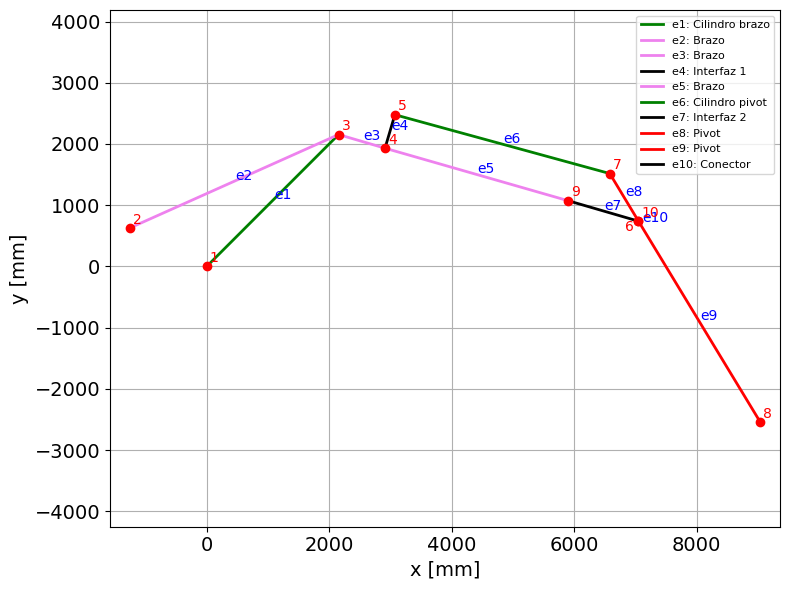

In [82]:
import matplotlib.pyplot as plt

def plot_mesh(connectivity_table, coords_by_node):
    plt.figure(figsize=(8, 6))

    for i, elem in enumerate(connectivity_table):
        n1, n2 = elem
        x1, y1 = coords_by_node[n1][0], coords_by_node[n1][1]
        x2, y2 = coords_by_node[n2][0], coords_by_node[n2][1]
        e = i + 1

        # Colores y etiquetas personalizadas
        if e == 1:
            color = 'g'
            label = f'e{e}: Cilindro brazo'
        elif e in [2, 3, 5]:
            color = 'violet'
            label = f'e{e}: Brazo'
        elif e == 4:
            color = 'k'
            label = f'e{e}: Interfaz 1'
        elif e == 6:
            color = 'g'
            label = f'e{e}: Cilindro pivot'
        elif e == 7:
            color = 'k'
            label = f'e{e}: Interfaz 2'
        elif e in [8, 9]:
            color = 'r'
            label = f'e{e}: Pivot'
        elif e == 10:
            color = 'k'
            label = f'e{e}: Conector'
        else:
            color = 'k'
            label = f'e{e}'

        # Solo agregar etiqueta a la leyenda una vez por tipo
        plt.plot([x1, x2], [y1, y2], '-', color=color, linewidth=2, label=label if i == connectivity_table.tolist().index(elem.tolist()) else None)

        # Etiqueta del elemento en el centro
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
        dx, dy = (20, 20) if i < 9 else (60, -20)
        plt.text(xm + dx, ym + dy, f"e{e}", fontsize=10, color='blue')

    # Etiquetar nodos
    for node_id, (x, y, _) in coords_by_node.items():
        plt.plot(x, y, 'ro')
        if node_id != 6:
            plt.text(x + 50, y + 70, str(node_id), fontsize=10, color='red')
        else:
            plt.text(x - 220, y - 155, str(node_id), fontsize=10, color='red')
    
    plt.xlabel("x [mm]", fontsize=14)
    plt.ylabel("y [mm]", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc='upper right', fontsize=8)
    #plt.savefig('Imagenes/mesh_modified.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_mesh(connectivity_table, coords_by_node)

### Longitudes de cada elemento

In [83]:

def calcular_longitudes(connectivity_table, coords_by_node):
    """
    Calcula la longitud de cada barra a partir de las coordenadas de nodos.
    
    Args:
        connectivity_table (np.ndarray): Matriz de conectividad (elementos x nodos)
        coords_by_node (dict): Diccionario {nodo_id: [x, y, z]}
    
    Returns:
        np.ndarray: Array de longitudes por elemento
    """
    longitudes = {}
    for i, conn in enumerate(connectivity_table):
        n1, n2 = conn
        x1, y1, _ = coords_by_node[n1]
        x2, y2, _ = coords_by_node[n2]

        L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        longitudes[i+1] = L


    return longitudes

L = calcular_longitudes(connectivity_table, coords_by_node)
L #[mm]

{1: 3046.216013351647,
 2: 3735.8768716326827,
 3: 790.1221424564685,
 4: 570.2017186926045,
 5: 3109.43242409286,
 6: 3639.1786161165546,
 7: 1198.760192865946,
 8: 908.4299642790302,
 9: 3835.4327004915626,
 10: 0.0}

### Angulos

In [84]:
def get_angles(coords_by_node, connectivity_table):
    ''' Obtiene los ángulos de cada barra en grados. '''
    
    ang = []
    angles = {}

    for elem in connectivity_table:
        n1, n2 = elem
        x1, y1, _ = coords_by_node[n1]
        x2, y2, _ = coords_by_node[n2]
        
        dx = x2 - x1
        dy = y2 - y1
        
        theta_rad = np.arctan2(dy, dx)  # ángulo en radianes
        theta_deg = np.degrees(theta_rad)  # convertir a grados

        ang.append(theta_deg)

    for i in range(len(ang)):
        angles[i+1] = ang[i]


    return angles

angles = get_angles(coords_by_node, connectivity_table)

angles #[grados]

{1: 45.0,
 2: 24.108865871813723,
 3: -16.393632597402807,
 4: 73.59911845876712,
 5: -15.99854830736426,
 6: -15.31173370306962,
 7: -16.22770351884119,
 8: 121.0827394787725,
 9: -58.780048701072566,
 10: 0.0}

### Parametros

In [85]:
'''SE CARGA A MANO'''

# == ESPESOR ==
t = 7 #[mm]
#t = 25
#t = 75

# == ALTURAS ==
y = {}
y_brazo = 1000
y_pivot = 900
y_interfaz_1 = 563
y_interfaz_2 = 563

y[1] = 0
y[2] = y_brazo
y[3] = y_brazo
y[4] = y_interfaz_1
y[5] = y_brazo
y[6] = 0
y[7] = y_interfaz_2
y[8] = y_pivot
y[9] = y_pivot
y[10] = 0


# == AREA ==
A = {}
A_brazo = 1000 * 1000 - (1000 - 2*t) * (1000 - 2*t) #[mm2]
A_pivot = 900 * 900 - (900 - 2*t) * (900 - 2*t) #[mm2]
A_interfaz_1 = 563 * 50 #[mm2]
A_interfaz_2 = 563 * 50 #[mm2]
A_cilindro_brazo = 53700 #[mm2]
A_cilindro_pivot = 31400 #[mm2]

A[1] = A_cilindro_brazo
A[2] = A_brazo
A[3] = A_brazo
A[4] = A_interfaz_1
A[5] = A_brazo
A[6] = A_cilindro_pivot
A[7] = A_interfaz_2
A[8] = A_pivot
A[9] = A_pivot
A[10] = 0

# == ANCHOS ==
b = {}
b[1] = np.sqrt(A[1]/np.pi) #radio
b[2] = 1000
b[3] = 1000
b[4] = 50
b[5] = 1000
b[6] = np.sqrt(A[6]/np.pi) #radio
b[7] = 50
b[8] = 900
b[9] = 900
b[10] = 0

# == MODULO DE ELASTICIDAD ==
Ee = 210000 #[MPa]
E = {}
E[1] = Ee
E[2] = Ee
E[3] = Ee
E[4] = Ee
E[5] = Ee
E[6] = Ee
E[7] = Ee
E[8] = Ee
E[9] = Ee
E[10] = Ee

# == MOMENTO DE INERCIA == 
I_brazo = 1/12 * ( y_brazo**4 - (y_brazo - 2*t)**4) #[mm4]
I_pivot = 1/12 * ( y_pivot**4 - (y_pivot - 2*t)**4) #[mm4]
I_interfaz_1 = b[4] * y_interfaz_1**3/12
I_interfaz_2 = b[7] * y_interfaz_2**3/12

I = {}
I[1] = 0
I[2] = I_brazo
I[3] = I_brazo
I[4] = I_interfaz_1
I[5] = I_brazo
I[6] = 0
I[7] = I_interfaz_2
I[8] = I_pivot
I[9] = I_pivot
I[10] = 0

# == GDL RESTRINGIDOS ==
total_dofs = len(np.unique(dof_table.flatten()))
#los que tienen desplazamiento impuesto (1)...los que no (0)
gdl_restringidos_desp = np.zeros(total_dofs)
gdl_restringidos_desp[0] = 1 
gdl_restringidos_desp[1] = 1 
gdl_restringidos_desp[2] = 1
gdl_restringidos_desp[3] = 1 
gdl_restringidos_desp[4] = 1 
 

print('GDL restringidos desplazamiento: ')
print(gdl_restringidos_desp)


GDL restringidos desplazamiento: 
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


### Fuerzas externas

In [86]:
def aplicar_cargas_distribuidas(total_dofs, connectivity_table, dof_table, element_type, A, L, angles, rho=7800e-9, g=9.81):

    F = np.zeros(total_dofs)  
    
    for i in range(len(connectivity_table)):
        eid = i + 1  # porque los diccionarios están indexados desde 1

        # Caracteristicas del elemento
        w = -rho * g * A[eid] 
        L_e = L[eid]
        theta = np.deg2rad(angles[eid])
    
        # Vector de fuerzas distribuidas de cada elemento
        if element_type[eid] == 'Viga':
            fe_local = np.array([
                0,
                w * L_e / 2,
                w * L_e**2 / 12 * np.cos(theta),
                0,
                w * L_e / 2,
                -w * L_e**2 / 12 * np.cos(theta)
            ])
        else:
            fe_local = np.array([
                0,
                w * L_e / 2,
                0,
                0,
                w * L_e / 2,
                0
            ])
        
    
        # Armo el vector de fuerzas 
        gdl = dof_table[i]
        for j in range(6): F[gdl[j] - 1] += fe_local[j] 

        
    return F

F_distribuida = aplicar_cargas_distribuidas(total_dofs, connectivity_table, dof_table,element_type, A, L, angles)

F_ext = np.zeros(total_dofs)  


F_ext[22-1] = 100000  #excavacion
#F_ext[23-1] = -20000 #levantamiento


F = F_distribuida + F_ext #[N y Nm]

print('Vector de fuerzas aplicadas: ')
sp.Matrix(F)


Vector de fuerzas aplicadas: 


Matrix([
[              0.0],
[-6258.47608302387],
[              0.0],
[              0.0],
[-3974.05111149682],
[-2258585.71503403],
[              0.0],
[ -11073.022180394],
[  2152403.1818187],
[              0.0],
[-4762.26582281163],
[-1558066.21350867],
[              0.0],
[-4985.96594244991],
[ 16478.4045705799],
[              0.0],
[-1291.05375906086],
[ 247667.146113175],
[              0.0],
[ -5240.8934813355],
[-67929.1449226956],
[         100000.0],
[-3669.08245148142],
[ 1215689.31892418],
[              0.0],
[-4598.72256231296],
[ 1400103.19604025],
[              0.0],
[-4538.11202405322],
[-1147760.17400148]])

### Matriz de rotacion

In [87]:
def get_rotation_matrix(angles_deg):
    """
    Genera matrices de rotación 2D para una lista de ángulos en grados para cada elemento.
    
    """
    dic = {}

    for i in range(len(angles_deg)):
        e = i + 1

        theta = np.radians(angles_deg[e])
        c = np.cos(theta)
        s = np.sin(theta)

        R = np.array([
                [ c,  s, 0, 0, 0, 0],
                [-s, c, 0, 0, 0, 0],
                [ 0, 0 , 1, 0, 0, 0],
                [ 0, 0, 0, c, s, 0 ],
                [ 0, 0, 0, -s, c, 0 ],
                [0, 0 , 0 , 0 , 0 , 1]
                ])

        dic[i+1] = R

    return dic
            
rotation_matrix = get_rotation_matrix(angles)

### Matrices de rigidez global

Matrices elementales de rigidez locales y globales

In [88]:
def rigidez(E, A, L, I, rotation_matrix,element_type,k_x=1e12, k_y=1e12, k_theta=0):
    """
    Esta función calcula las matrices de rigidez elementales, en el sdr local y global.
    """
     
    k_locales = {}
    k_globales = {}

    for i in range(len(rotation_matrix)): 
        
        e = i+1
        
        if element_type[e] == 'Conector':
            
            k = np.array([
                [ k_x, 0, 0, -k_x, 0, 0],
                [0, k_y, 0, 0, -k_y, 0],
                [0, 0, k_theta,0 , 0, -k_theta],
                [-k_x, 0, 0, k_x, 0, 0],
                [0, -k_y, 0, 0, k_y, 0],
                [0, 0 , -k_theta , 0 , 0 , k_theta]
            ]) 
        else:
            k = np.array([
                [ E[e]*A[e]/L[e],  0, 0, -E[e]*A[e]/L[e], 0, 0],
                [0, 12*E[e]*I[e]/(L[e]**3), 6*E[e]*I[e]/(L[e]**2), 0, -12*E[e]*I[e]/(L[e]**3), 6*E[e]*I[e]/(L[e]**2)],
                [ 0, 6*E[e]*I[e]/(L[e]**2) , 4*E[e]*I[e]/(L[e]), 0, -6*E[e]*I[e]/(L[e]**2), 2*E[e]*I[e]/(L[e])],
                [-E[e]*A[e]/L[e], 0, 0, E[e]*A[e]/L[e], 0, 0 ],
                [0, -12*E[e]*I[e]/(L[e]**3), -6*E[e]*I[e]/(L[e]**2), 0, 12*E[e]*I[e]/(L[e]**3), -6*E[e]*I[e]/(L[e]**2)],
               [0, 6*E[e]*I[e]/(L[e]**2) , 2*E[e]*I[e]/(L[e]) , 0 , -6*E[e]*I[e]/(L[e]**2) , 4*E[e]*I[e]/(L[e])]
                ]) 
        
        k_locales[e] = k  # [N/mm]

        R = rotation_matrix[e]
        k_globales[e] = (R.T @ k_locales[e] @ R)  # [N/mm]

   
    return k_globales, k_locales                               

K,k = rigidez(E, A, L, I, rotation_matrix,element_type)


for i in range(len(rotation_matrix)):
    print(f"Elemento {i+1} - k_global:")
    display(sp.Matrix(np.round(K[i+1])))

Elemento 1 - k_global:


Matrix([
[ 1850985.0,  1850985.0, 0.0, -1850985.0, -1850985.0, 0.0],
[ 1850985.0,  1850985.0, 0.0, -1850985.0, -1850985.0, 0.0],
[       0.0,        0.0, 0.0,        0.0,        0.0, 0.0],
[-1850985.0, -1850985.0, 0.0,  1850985.0,  1850985.0, 0.0],
[-1850985.0, -1850985.0, 0.0,  1850985.0,  1850985.0, 0.0],
[       0.0,        0.0, 0.0,        0.0,        0.0, 0.0]])

Elemento 2 - k_global:


Matrix([
[   1338989.0,    500375.0,    -168509164.0,  -1338989.0,    -500375.0,    -168509164.0],
[    500375.0,    444772.0,     376550622.0,   -500375.0,    -444772.0,     376550622.0],
[-168509164.0, 376550622.0, 1027455069525.0, 168509164.0, -376550622.0,  513727534762.0],
[  -1338989.0,   -500375.0,     168509164.0,   1338989.0,     500375.0,     168509164.0],
[   -500375.0,   -444772.0,    -376550622.0,    500375.0,     444772.0,    -376550622.0],
[-168509164.0, 376550622.0,  513727534762.0, 168509164.0, -376550622.0, 1027455069525.0]])

Elemento 3 - k_global:


Matrix([
[   8660730.0,    4320043.0,    2602967931.0,    -8660730.0,    -4320043.0,    2602967931.0],
[   4320043.0,   22074068.0,    8847756465.0,    -4320043.0,   -22074068.0,    8847756465.0],
[2602967931.0, 8847756465.0, 4858040832708.0, -2602967931.0, -8847756465.0, 2429020416354.0],
[  -8660730.0,   -4320043.0,   -2602967931.0,     8660730.0,     4320043.0,   -2602967931.0],
[  -4320043.0,  -22074068.0,   -8847756465.0,     4320043.0,    22074068.0,   -8847756465.0],
[2602967931.0, 8847756465.0, 2429020416354.0, -2602967931.0, -8847756465.0, 4858040832708.0]])

Elemento 4 - k_global:


Matrix([
[   10127902.0,     70487.0,   -2764306839.0,  -10127902.0,     -70487.0,   -2764306839.0],
[      70487.0,  10346637.0,     813625962.0,     -70487.0,  -10346637.0,     813625962.0],
[-2764306839.0, 813625962.0, 1095379747245.0, 2764306839.0, -813625962.0,  547689873622.0],
[  -10127902.0,    -70487.0,    2764306839.0,   10127902.0,      70487.0,    2764306839.0],
[     -70487.0, -10346637.0,    -813625962.0,      70487.0,   10346637.0,    -813625962.0],
[-2764306839.0, 813625962.0,  547689873622.0, 2764306839.0, -813625962.0, 1095379747245.0]])

Elemento 5 - k_global:


Matrix([
[  1764238.0,   -396017.0,     164128540.0,   -1764238.0,     396017.0,     164128540.0],
[  -396017.0,    496576.0,     572438979.0,     396017.0,    -496576.0,     572438979.0],
[164128540.0, 572438979.0, 1234452178841.0, -164128540.0, -572438979.0,  617226089420.0],
[ -1764238.0,    396017.0,    -164128540.0,    1764238.0,    -396017.0,    -164128540.0],
[   396017.0,   -496576.0,    -572438979.0,    -396017.0,     496576.0,    -572438979.0],
[164128540.0, 572438979.0,  617226089420.0, -164128540.0, -572438979.0, 1234452178841.0]])

Elemento 6 - k_global:


Matrix([
[ 1685594.0, -461497.0, 0.0, -1685594.0,  461497.0, 0.0],
[ -461497.0,  126353.0, 0.0,   461497.0, -126353.0, 0.0],
[       0.0,       0.0, 0.0,        0.0,       0.0, 0.0],
[-1685594.0,  461497.0, 0.0,  1685594.0, -461497.0, 0.0],
[  461497.0, -126353.0, 0.0,  -461497.0,  126353.0, 0.0],
[       0.0,       0.0, 0.0,        0.0,       0.0, 0.0]])

Elemento 7 - k_global:


Matrix([
[  4631176.0,  -1031327.0,    182193281.0,   -4631176.0,    1031327.0,    182193281.0],
[ -1031327.0,   1387890.0,    625983481.0,    1031327.0,   -1387890.0,    625983481.0],
[182193281.0, 625983481.0, 521027823761.0, -182193281.0, -625983481.0, 260513911880.0],
[ -4631176.0,   1031327.0,   -182193281.0,    4631176.0,   -1031327.0,   -182193281.0],
[  1031327.0,  -1387890.0,   -625983481.0,   -1031327.0,    1387890.0,   -625983481.0],
[182193281.0, 625983481.0, 260513911880.0, -182193281.0, -625983481.0, 521027823761.0]])

Elemento 8 - k_global:


Matrix([
[    9734530.0,     2383824.0,   -4345738924.0,   -9734530.0,   -2383824.0,   -4345738924.0],
[    2383824.0,     7217162.0,   -2619732076.0,   -2383824.0,   -7217162.0,   -2619732076.0],
[-4345738924.0, -2619732076.0, 3073092817998.0, 4345738924.0, 2619732076.0, 1536546408999.0],
[   -9734530.0,    -2383824.0,    4345738924.0,    9734530.0,    2383824.0,    4345738924.0],
[   -2383824.0,    -7217162.0,    2619732076.0,    2383824.0,    7217162.0,    2619732076.0],
[-4345738924.0, -2619732076.0, 1536546408999.0, 4345738924.0, 2619732076.0, 3073092817998.0]])

Elemento 9 - k_global:


Matrix([
[   476364.0,   -541045.0,    243438426.0,    -476364.0,     541045.0,    243438426.0],
[  -541045.0,   1041108.0,    147547436.0,     541045.0,   -1041108.0,    147547436.0],
[243438426.0, 147547436.0, 727868226842.0, -243438426.0, -147547436.0, 363934113421.0],
[  -476364.0,    541045.0,   -243438426.0,     476364.0,    -541045.0,   -243438426.0],
[   541045.0,  -1041108.0,   -147547436.0,    -541045.0,    1041108.0,   -147547436.0],
[243438426.0, 147547436.0, 363934113421.0, -243438426.0, -147547436.0, 727868226842.0]])

Elemento 10 - k_global:


Matrix([
[ 1000000000000.0,              0.0, 0.0, -1000000000000.0,              0.0, 0.0],
[             0.0,  1000000000000.0, 0.0,              0.0, -1000000000000.0, 0.0],
[             0.0,              0.0, 0.0,              0.0,              0.0, 0.0],
[-1000000000000.0,              0.0, 0.0,  1000000000000.0,              0.0, 0.0],
[             0.0, -1000000000000.0, 0.0,              0.0,  1000000000000.0, 0.0],
[             0.0,              0.0, 0.0,              0.0,              0.0, 0.0]])

Matriz de rigidez global

In [89]:
def ensamblar_K_global(K, dof_table, connectivity_table):
    """
    Ensambla las matrices de rigidez globales de cada elemento en la matriz global.
    """
    total_nods = len(np.unique(connectivity_table))
    dofs_per_node = 3
    total_dofs = total_nods * dofs_per_node

    KG = np.zeros((total_dofs, total_dofs))

    n_dof_elem = dof_table.shape[1]  # = 6 si vigas

    for i in range(len(K)):
        e = i + 1
        ke = K[e]  # Diccionario con claves desde 1
        gdl = dof_table[i]

        for i in range(n_dof_elem):
            for j in range(n_dof_elem):
                KG[gdl[i]-1, gdl[j]-1] += ke[i, j]  # -1 si base 1

    return KG

KG = ensamblar_K_global(K, dof_table, connectivity_table)
print('Matriz de rigidez global:')
sp.Matrix(np.round(KG,3))

Matriz de rigidez global:


Matrix([
[ 1850984.952,  1850984.952, 0.0,            0.0,           0.0,              0.0,   -1850984.952,   -1850984.952,              0.0,             0.0,             0.0,              0.0,            0.0,            0.0,              0.0,              0.0,              0.0,              0.0,            0.0,            0.0,              0.0,            0.0,            0.0,             0.0,            0.0,           0.0,              0.0,              0.0,              0.0,              0.0],
[ 1850984.952,  1850984.952, 0.0,            0.0,           0.0,              0.0,   -1850984.952,   -1850984.952,              0.0,             0.0,             0.0,              0.0,            0.0,            0.0,              0.0,              0.0,              0.0,              0.0,            0.0,            0.0,              0.0,            0.0,            0.0,             0.0,            0.0,           0.0,              0.0,              0.0,              0.0,              0.0],
[      

chequeo simetria

In [90]:
simetry = KG - np.transpose(KG)
if np.all(np.abs(simetry) < 1e-7):
    print("La matriz de rigidez es simétrica!")

La matriz de rigidez es simétrica!


### Condiciones de borde

Obtengo la matriz reducida de rigidez y fuerza, segun mis CB

In [91]:
def aplicar_condiciones_borde(K, F, gdl_restringidos_desp):

    K_mod = K.copy()
    F_mod = F.copy()

    for i in range(len(gdl_restringidos_desp)):

        if gdl_restringidos_desp[i] == 1:
            K_mod[i, :] = 0
            K_mod[:, i] = 0
            K_mod[i, i] = 1
            F_mod[i] = 0
        
    return K_mod,F_mod


K_reducida , F_reducida = aplicar_condiciones_borde(KG, F, gdl_restringidos_desp)

print('Matriz de rigidez reducida:')
sp.Matrix(np.round(K_reducida,3))

Matriz de rigidez reducida:


Matrix([
[1.0, 0.0, 0.0, 0.0, 0.0,              0.0,            0.0,            0.0,              0.0,             0.0,             0.0,              0.0,            0.0,            0.0,              0.0,              0.0,              0.0,              0.0,            0.0,            0.0,              0.0,            0.0,            0.0,             0.0,            0.0,           0.0,              0.0,              0.0,              0.0,              0.0],
[0.0, 1.0, 0.0, 0.0, 0.0,              0.0,            0.0,            0.0,              0.0,             0.0,             0.0,              0.0,            0.0,            0.0,              0.0,              0.0,              0.0,              0.0,            0.0,            0.0,              0.0,            0.0,            0.0,             0.0,            0.0,           0.0,              0.0,              0.0,              0.0,              0.0],
[0.0, 0.0, 1.0, 0.0, 0.0,              0.0,            0.0,            0.0,          

In [92]:
print('Vector de fuerzas reducido:')
sp.Matrix(np.round(F_reducida,3))

Vector de fuerzas reducido:


Matrix([
[         0.0],
[         0.0],
[         0.0],
[         0.0],
[         0.0],
[-2258585.715],
[         0.0],
[  -11073.022],
[ 2152403.182],
[         0.0],
[   -4762.266],
[-1558066.214],
[         0.0],
[   -4985.966],
[   16478.405],
[         0.0],
[   -1291.054],
[  247667.146],
[         0.0],
[   -5240.893],
[  -67929.145],
[    100000.0],
[   -3669.082],
[ 1215689.319],
[         0.0],
[   -4598.723],
[ 1400103.196],
[         0.0],
[   -4538.112],
[-1147760.174]])

### Desplazamientos

Desplazamiento global

In [93]:
UG = np.linalg.solve(K_reducida, F_reducida) #[mm]

print('Desplazamientos globales:')
sp.Matrix(UG)

Desplazamientos globales:


Matrix([
[                  0.0],
[                  0.0],
[                  0.0],
[                  0.0],
[                  0.0],
[-0.000239966692928235],
[  0.00803124917047665],
[   0.0141941396492565],
[ 0.000483306550025128],
[     0.16302801568825],
[    0.491110889244208],
[ 0.000785509050639435],
[   -0.462314092691881],
[    0.673702809545342],
[  0.00132100317095374],
[     1.69683212536011],
[     4.17715111787218],
[  0.00105611908400271],
[   -0.118823471043077],
[     3.00626720171705],
[  0.00230752546578931],
[     11.9091054477053],
[     10.3198326121653],
[  0.00340423290955611],
[     1.23476315494622],
[     3.03646185301122],
[ 0.000952804154492026],
[     1.69683272284685],
[      4.1771509682176],
[  0.00251633251548027]])

Desplazamiento elementales referido al sdr global

In [94]:
def desplazamiento_elemental_sdrglobal(dof_table,UG):
    '''Obtengo los vectores de desplazamiento de cada elemento en el sdr global'''
    Uel = {}
    
    for i in range(len(dof_table)):
        dofs = dof_table[i] - 1  # ajustar por base 1
        Ue = UG[dofs]
        Uel[i+1] = Ue

    return Uel

Uel = desplazamiento_elemental_sdrglobal(dof_table,UG)
for i, u in Uel.items():
    print(f'\nElemento {i}:')
    display(sp.Matrix(u))


Elemento 1:


Matrix([
[                 0.0],
[                 0.0],
[                 0.0],
[ 0.00803124917047665],
[  0.0141941396492565],
[0.000483306550025128]])


Elemento 2:


Matrix([
[                  0.0],
[                  0.0],
[-0.000239966692928235],
[  0.00803124917047665],
[   0.0141941396492565],
[ 0.000483306550025128]])


Elemento 3:


Matrix([
[ 0.00803124917047665],
[  0.0141941396492565],
[0.000483306550025128],
[    0.16302801568825],
[   0.491110889244208],
[0.000785509050639435]])


Elemento 4:


Matrix([
[    0.16302801568825],
[   0.491110889244208],
[0.000785509050639435],
[  -0.462314092691881],
[   0.673702809545342],
[ 0.00132100317095374]])


Elemento 5:


Matrix([
[    0.16302801568825],
[   0.491110889244208],
[0.000785509050639435],
[    1.23476315494622],
[    3.03646185301122],
[0.000952804154492026]])


Elemento 6:


Matrix([
[ -0.462314092691881],
[  0.673702809545342],
[0.00132100317095374],
[ -0.118823471043077],
[   3.00626720171705],
[0.00230752546578931]])


Elemento 7:


Matrix([
[    1.23476315494622],
[    3.03646185301122],
[0.000952804154492026],
[    1.69683212536011],
[    4.17715111787218],
[ 0.00105611908400271]])


Elemento 8:


Matrix([
[   1.69683272284685],
[    4.1771509682176],
[0.00251633251548027],
[ -0.118823471043077],
[   3.00626720171705],
[0.00230752546578931]])


Elemento 9:


Matrix([
[   1.69683272284685],
[    4.1771509682176],
[0.00251633251548027],
[   11.9091054477053],
[   10.3198326121653],
[0.00340423290955611]])


Elemento 10:


Matrix([
[   1.69683212536011],
[   4.17715111787218],
[0.00105611908400271],
[   1.69683272284685],
[    4.1771509682176],
[0.00251633251548027]])

Desplazamiento del sistema

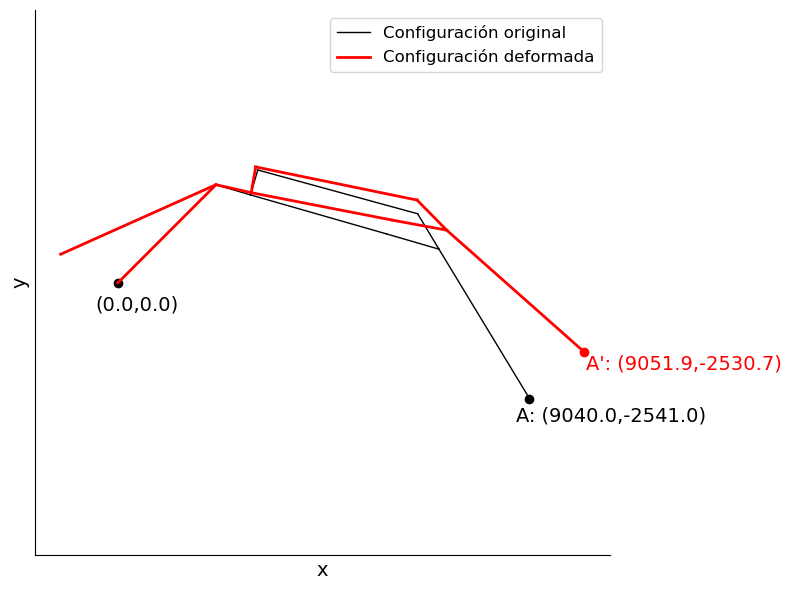

In [95]:
def plot_final_mesh(connectivity_table, coords_by_node, Uel, factor=100):
    
    """ 
    Plotea la malla original y la deformada.
    """ 


    fig, ax = plt.subplots(figsize=(8, 6))
    
    # == MALLA ORIGINAL ==
    for i, elem in enumerate(connectivity_table):
        e = i + 1
        n1, n2 = elem
        x1, y1 = coords_by_node[n1][0], coords_by_node[n1][1]
        x2, y2 = coords_by_node[n2][0], coords_by_node[n2][1]
        
        label = 'Configuración original' if i == 0 else None
        ax.plot([x1, x2], [y1, y2], 'k-', linewidth=1, label=label)


        if e == 9:
            ax.plot(x2, y2, 'ko')  # punto negro
            ax.text(x2 - 300, y2 - 500, f'A: ({x2},{y2})', fontsize=14, color='black')
            A_inicial = (x2, y2)

        if e == 1: #origen
            ax.plot(x1, y1, 'ko')  # punto negro
            ax.text(x1 - 500, y1 - 600, f'({x1},{y1})', fontsize=14, color='black')

    # == MALLA DEFORMADA ==
    for i, elem in enumerate(connectivity_table):
        e = i + 1
        n1, n2 = elem
        x1, y1 = coords_by_node[n1][0], coords_by_node[n1][1]
        x2, y2 = coords_by_node[n2][0], coords_by_node[n2][1]

        u1, v1, _ = Uel[e][:3] * factor
        u2, v2, _ = Uel[e][3:] * factor

        x1_new = x1 + u1
        y1_new = y1 + v1
        x2_new = x2 + u2
        y2_new = y2 + v2

        label = 'Configuración deformada' if i == 0 else None
        ax.plot([x1_new, x2_new], [y1_new, y2_new], 'r-', linewidth=2, label=label)

        if e == 9:
            x2_new_new = np.round(x2 + u2 / factor,1)
            y2_new_new = np.round(y2 + v2 / factor,1)
            ax.plot(x2_new, y2_new, 'ro')  # punto rojo
            ax.text(x2_new + 50, y2_new - 400, f"A': ({x2_new_new},{y2_new_new})", fontsize=14, color='red')
            A_final = (x2_new_new, y2_new_new)
            #print(f"Posición deformada del punto A (nodo {n2} del elemento 9): ({x2_new:.2f}, {y2_new:.2f})")

    # Estética del gráfico
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_xticks([])  # sin valores numéricos
    ax.set_yticks([])
    ax.axis("equal")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(fontsize=12, loc='upper right')

    # Ocultar los ejes superior y derecho
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    #plt.savefig('Imagenes/7mm_excavacion.png', dpi=300, bbox_inches='tight')
    plt.show()

    return A_inicial, A_final

A_inicial , A_final = plot_final_mesh(connectivity_table, coords_by_node, Uel)

Desplazamiento elementales referido al sdr local

In [96]:
def desplazamiento_elemental_sdrlocal(Uel, rotation_matrix):
    '''Obtengo los vectores de desplazamiento de cada elemento en el sdr local'''
    uel = {}
    for i in range(len(Uel)):
        uel[i+1] = rotation_matrix[i+1] @ Uel[i+1]
    return uel

uel = desplazamiento_elemental_sdrlocal(Uel, rotation_matrix)

tol = 1e-4 # Umbral para considerar como cero

for i, u in uel.items():
    print(f'\nElemento {i}:')
    u_clean = [0.0 if abs(val) < tol else val for val in u]
    display(sp.Matrix(u_clean))



Elemento 1:


Matrix([
[                 0.0],
[                 0.0],
[                 0.0],
[   0.015715723148941],
[ 0.00435782164925524],
[0.000483306550025128]])


Elemento 2:


Matrix([
[                  0.0],
[                  0.0],
[-0.000239966692928235],
[   0.0131285956313266],
[  0.00967546073166494],
[ 0.000483306550025128]])


Elemento 3:


Matrix([
[ 0.00369866071636906],
[  0.0158837801711704],
[0.000483306550025128],
[  0.0177915626393289],
[   0.517157132535495],
[0.000785509050639435]])


Elemento 4:


Matrix([
[    0.51715937934828],
[ -0.0177261328435318],
[0.000785509050639435],
[   0.515752335107305],
[   0.633726537808042],
[ 0.00132100317095374]])


Elemento 5:


Matrix([
[  0.0213571796239524],
[   0.517022156500082],
[0.000785509050639435],
[    0.35005078536839],
[    3.25917245344091],
[0.000952804154492026]])


Elemento 6:


Matrix([
[ -0.623808585615428],
[  0.527705073315848],
[0.00132100317095374],
[ -0.908472354055347],
[   2.86817703207238],
[0.00230752546578931]])


Elemento 7:


Matrix([
[   0.337012918003627],
[    3.26054641535798],
[0.000952804154492026],
[   0.461900682970231],
[    4.48491677540024],
[ 0.00105611908400271]])


Elemento 8:


Matrix([
[   2.70137380178309],
[  -3.60976607048782],
[0.00251633251548027],
[   2.63598096167549],
[  -1.45029854687742],
[0.00230752546578931]])


Elemento 9:


Matrix([
[  -2.69272140309242],
[   3.61622495787155],
[0.00251633251548027],
[  -2.65256885789188],
[   15.5334998040306],
[0.00340423290955611]])


Elemento 10:


Matrix([
[   1.69683212536011],
[   4.17715111787218],
[0.00105611908400271],
[   1.69683272284685],
[    4.1771509682176],
[0.00251633251548027]])

### Vectores de fuerzas

Vector de fuerza global

In [97]:
FG = KG @ UG

FG_clean = [0 if abs(val) < 1e-6 else val for val in FG]

print('Fuerzas globales:')
sp.Matrix(FG_clean) #[N]

Fuerzas globales:


Matrix([
[    -41138.8602485161],
[    -41138.8602485161],
[                    0],
[    -58861.1395454134],
[     81297.9793799771],
[    -2258585.71503404],
[                    0],
[    -11073.0221804045],
[     2152403.18181896],
[                    0],
[    -4762.26582281291],
[    -1558066.21350861],
[                    0],
[    -4985.96594244707],
[     16478.4045704603],
[  1.49775296449661e-5],
[    -1291.05322265625],
[     247667.146113396],
[                    0],
[    -5240.89348134398],
[    -67929.1449241638],
[      99999.999999997],
[    -3669.08245147672],
[     1215689.31892395],
[                    0],
[    -4598.72256231215],
[     1400103.19604015],
[-0.000104758888483047],
[    -4538.11279296875],
[    -1147760.17400312]])

### Reacciones

In [98]:
R = FG - F #N

R_clean = [0 if abs(val) < 1e-6 else val for val in R]

print('Reacciones:')
display(sp.Matrix(R_clean))

Reacciones:


Matrix([
[    -41138.8602485161],
[    -34880.3841654922],
[                    0],
[    -58861.1395454134],
[      85272.030491474],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[  1.49775296449661e-5],
[ 0.000536404609192687],
[                    0],
[                    0],
[                    0],
[ -1.46820093505085e-6],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[                    0],
[-0.000104758888483047],
[-0.000768915531807579],
[  -1.6423873603344e-6]])

Equilibrio de fuerzas

In [99]:
def equilibrio(FG):
    """
    Esta función verifica el equilibrio de fuerzas en el sistema.
    """
    Fx, Fy, M = [], [], []

    for i in range(0, len(FG), 3):
        Fx.append(FG[i])     # Fx
        Fy.append(FG[i + 1]) # Fy
    
    
    return np.sum(Fx), np.sum(Fy)

Fx, Fy = equilibrio(FG)

print(f"SumFx: {Fx}, SumFy: {Fy}")

SumFx: 0.00011628582433331758, SumFy: 0.0006750386819476262


Fuerzas elementales en el sdr global y local

In [100]:
def fuerzas_elementales(K,Uel,rotation_matrix):
    '''Obtengo las fuerzas elementales en el sdr global y local'''

    F_el = {}
    f_el = {}

    for i in range(len(K)):
        F_el[i+1] = K[i+1] @ Uel[i+1]
        f_el[i+1] = rotation_matrix[i+1] @ F_el[i+1]

    return F_el,f_el

F_el,f_el = fuerzas_elementales(K,Uel,rotation_matrix)


for i, f in f_el.items():
    print(f'\nElemento {i}:')
    display(sp.Matrix(f))


Elemento 1:


Matrix([
[    -58179.1341040229],
[-3.63797880709171e-12],
[                  0.0],
[     58179.1341040229],
[ 3.63797880709171e-12],
[                  0.0]])


Elemento 2:


Matrix([
[-20518.8157827359],
[ 98249.5465573555],
[-2258585.71503404],
[ 20518.8157827359],
[-98249.5465573555],
[ 369306794.347057]])


Elemento 3:


Matrix([
[-104143.644434555],
[-319.872652032514],
[-367154391.165239],
[ 104143.644434555],
[ 319.872652032514],
[ 366901652.700098]])


Elemento 4:


Matrix([
[ 14587.3675189897],
[-514294.749836428],
[-293268228.675885],
[-14587.3675189897],
[ 514294.749836428],
[ 16478.4045705795]])


Elemento 5:


Matrix([
[ -617215.33425019],
[-15155.2024029161],
[-75191490.2377207],
[  617215.33425019],
[ 15155.2024029161],
[  28067412.492403]])


Elemento 6:


Matrix([
[ 515795.756982077],
[              0.0],
[              0.0],
[-515795.756982077],
[              0.0],
[              0.0]])


Elemento 7:


Matrix([
[-615864.646652173],
[-22039.1386930262],
[-26667309.2963629],
[ 615864.646652173],
[ 22039.1386930262],
[ 247667.146113396]])


Elemento 8:


Matrix([
[ 377978.880103471],
[   353033.1194447],
[ 320773793.231384],
[-377978.880103471],
[  -353033.1194447],
[-67929.1449222565]])


Elemento 9:


Matrix([
[-54970.2228939697],
[-83616.6057731506],
[-321921553.405385],
[ 54970.2228939697],
[ 83616.6057731506],
[ 1215689.31892455]])


Elemento 10:


Matrix([
[-597486.739990234],
[ 149654.572265625],
[              0.0],
[ 597486.739990234],
[-149654.572265625],
[              0.0]])

### Contrapeso

In [101]:
def contrapeso(coords_by_node,R):
    #Condiciones en nodo 2
    x2_,y2_,_ = coords_by_node[2] #mm a m
    x2 = x2_ / 1000
    y2 = y2_ / 1000
    Rx2 = -R[3]
    Ry2 = -R[4]

    M2 = Ry2 * np.abs(x2) + Rx2 * np.abs(y2)

    #Contrapeso
    g = 9.81
    m = 14000
    x_contrapeso = -3000/1000
    M_contrapeso = m*g*np.abs(x_contrapeso)

    M_total = -M2 + M_contrapeso

    if M_total >= 0:
        print('Condicion segura')
    if M_total < 0:
        print('Condicion insegura')


    return M2, M_contrapeso , M_total

M2 , M_contrapeso , M_total = contrapeso(coords_by_node,R)
M2 , M_contrapeso , M_total

Condicion segura


(-70136.87466277166, 412020.0, 482156.87466277165)

### Deformaciones

In [102]:
def deformaciones(uel, L):
    '''Obtengo las deformaciones en cada elemento'''
    epsilon = {}

    for i in range(len(uel)):
        e = i + 1
        uel_i = uel[e]
        L_e = L[e]

        # Deformación axial
        epsilon[e] = (uel_i[0] - uel_i[3]) / L_e

    return epsilon
epsilon = deformaciones(uel, L)

#for i, e in epsilon.items():
 #   print(f'\nElemento {i}:')
  #  print(e)

### Tensiones

In [103]:
def tensiones(f_el, A, I, y, t, b,element_type):

    '''    
    Obtengo la tension maxima en cada nodo del elemento
    '''
    sigma = {} 
    sigma_VM = {}

    for i in range(len(f_el)):
        e = i + 1

        f = f_el[e]
        Ni,Vi,mi,Nj,Vj,mj = f
       
        # Tensiones por fuerza normales 
        sigma_A_i = np.abs(Ni) / A[e]  # [N/mm2]
        sigma_A_j = np.abs(Nj) / A[e] # [N/mm2]

        sigma_i = sigma_A_i
        sigma_j = sigma_A_j


        # Tensiones por flexión
        if element_type[e] == 'Viga':
            sigma_M_i = np.abs(mi) * (y[e]/2) / I[e]  # [N/mm2]
            sigma_M_j = np.abs(mj) * (y[e]/2) / I[e]

            sigma_i += sigma_M_i
            sigma_j += sigma_M_j
        
        # Tensiones por cortante
        if e == 1 or e == 6:
            #barras cilíndricas
            tau_i = 4 * Vi / (3*np.pi*b[e]**2)
            tau_j = 4 * Vj / (3*np.pi*b[e]**2)

        if e == 2 or e == 3 or e == 5 or e == 8 or e == 9:
            #tubular cuadrada hueca
            Q = t/8 * (b[e]-2*t)**2
            tau_i = Vi * Q / (b[e]*I[e])
            tau_j = Vj * Q / (b[e]*I[e])

        if e == 4 or e == 7:
            #area rectangular (interfaces)
            Q = b[e] * y[e]**2 / 8
            tau_i = Vi * Q / (b[e]*I[e])
            tau_j = Vj * Q / (b[e]*I[e])

        #print(tau_i, tau_j)
        sigma_i += np.abs(tau_i)
        sigma_j += np.abs(tau_j)

        if Ni < 0:  sigma_i = -sigma_i
        if Nj < 0:  sigma_j = -sigma_j

        # Tensiones del elemento
        sigma[e] = np.array([sigma_i, sigma_j])

        # Tensiones de Von Mises
        if np.abs(sigma_i) > np.abs(sigma_j):
            sigma_VM[e] = np.sqrt(sigma_i**2 + 3*tau_i**2)
        else:
            sigma_VM[e] = np.sqrt(sigma_j**2 + 3*tau_j**2)
        
    return sigma , sigma_VM#[Mpa]
        

sigma,sigma_VM = tensiones(f_el, A, I, y, t, b,element_type)

for i, s in sigma.items():
    print(f'\nElemento {i}:')
    display(sp.Matrix(s))
    print(f'Tension Von Mises: {sigma_VM[i]} [MPa]') #Mpa
    #print('Deformacion: ', epsilon[i]) #mm/mm





Elemento 1:


Matrix([
[-1.08341031851067],
[ 1.08341031851067]])

Tension Von Mises: 1.083410318510668 [MPa]

Elemento 2:


Matrix([
[-1.00340367283355],
[ 41.1655584745695]])

Tension Von Mises: 41.16557066418044 [MPa]

Elemento 3:


Matrix([
[-43.919468086565],
[43.8918136228661]])

Tension Von Mises: 43.91946808668606 [MPa]

Elemento 4:


Matrix([
[  138.95011664897],
[-27.9291334217213]])

Tension Von Mises: 146.8338741918683 [MPa]

Elemento 5:


Matrix([
[-30.4290172192191],
[ 25.2727340368269]])

Tension Von Mises: 30.429017611591448 [MPa]

Elemento 6:


Matrix([
[ 16.4266164643974],
[-16.4266164643974]])

Tension Von Mises: 16.426616464397366 [MPa]

Elemento 7:


Matrix([
[-33.1482072044655],
[ 23.1461027146576]])

Tension Von Mises: 33.21055741410474 [MPa]

Elemento 8:


Matrix([
[ 58.6311789578417],
[-15.2070043385295]])

Tension Von Mises: 58.63134710254818 [MPa]

Elemento 9:


Matrix([
[-45.8064400040002],
[ 2.38226538468833]])

Tension Von Mises: 45.8064520776902 [MPa]

Elemento 10:


Matrix([
[-oo],
[ oo]])

Tension Von Mises: inf [MPa]


### Valores importantes de reporte

In [104]:
print('espesor: ',t)    

print('---')
print('Tension maxima de VM:')
finite_vm = [v for v in sigma_VM.values() if np.isfinite(v)]
if finite_vm:
    max_vm = np.max(finite_vm)
    max_vm_elem = np.argmax(finite_vm) + 1
    print('VM max: ', max_vm, 'MPa')
    print('Elemento con max VM: ', max_vm_elem)

print('---')
print('Reacciones en los anclajes:')
print('R nodo 1 --> Rx: ',R[0], 'Ry: ',R[1])
print('R nodo 2 --> Rx: ',R[3], 'Ry: ',R[4])

print('---')

print('Fuerzas en los actuadores:')
print('Fuerza actuador 1 (elemento 1): ', f_el[1][3], 'N')
print('Fuerza actuador 2 (elemento 6): ', f_el[6][3], 'N')

print('---')

print('Posicion inicial del punto A: ', A_inicial)
print('Posicion final del punto A: ', A_final)
print('Desplazamiento del punto A en x: ', np.round(A_final[0] - A_inicial[0],3), 'mm')
print('Desplazamiento del punto A en y: ', np.round(A_final[1] - A_inicial[1],3), 'mm')

espesor:  7
---
Tension maxima de VM:
VM max:  146.8338741918683 MPa
Elemento con max VM:  4
---
Reacciones en los anclajes:
R nodo 1 --> Rx:  -41138.86024851611 Ry:  -34880.38416549224
R nodo 2 --> Rx:  -58861.13954541345 Ry:  85272.03049147397
---
Fuerzas en los actuadores:
Fuerza actuador 1 (elemento 1):  58179.13410402287 N
Fuerza actuador 2 (elemento 6):  -515795.7569820773 N
---
Posicion inicial del punto A:  (9040.0, -2541.0)
Posicion final del punto A:  (9051.9, -2530.7)
Desplazamiento del punto A en x:  11.9 mm
Desplazamiento del punto A en y:  10.3 mm
